In [1]:
import os
import json

def is_valid_segment(segment):
    return len(segment['speakers']) == 1 \
            and len(segment['ivectors']) == 1 \
            and len(segment['xvectors']) == 1 \
            and segment['speakers'][0]['speaker_id'] in ['A', 'B']

directory = '../exp/json'
filenames = [filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))]

recordings_segments = {}
recordings_length = len(filenames)
recordings_count = 0
for filename in filenames:
    recording_id = filename.split('.')[0]
    filepath = os.path.join(directory, filename)
    file = open(filepath, 'r')
    recordings_segments[recording_id] = [json.loads(line) for line in file.readlines()]
    file.close()
    recordings_segments[recording_id] = list(filter(is_valid_segment, recordings_segments[recording_id]))
    recordings_count += 1
    print('Loading data: ' + str(recordings_count) + '/' + str(recordings_length), end = '\r')

## Balancing the dataset

In [2]:
from functools import reduce

def speakers_get_indexes(accumulator, speaker_tuple):
    speaker_id, index = speaker_tuple
    if speaker_id in accumulator:
        accumulator[speaker_id].append(index)
    else:
        accumulator[speaker_id] = [index]
    return accumulator

recordings_segments_cut = {}
for recording_id in recordings_segments:
    recording_segments = recordings_segments[recording_id]
    speakers_indexes = [(segment['speakers'][0]['speaker_id'], index) for index, segment in enumerate(recording_segments)]
    speakers_indexes = reduce(speakers_get_indexes, speakers_indexes, {})
    speakers_lengths = [(speaker_id, len(speakers_indexes[speaker_id])) for speaker_id in speakers_indexes]
    speakers_lengths.sort(key = lambda x: x[1])
    speakers_lengths_min = speakers_lengths[0][1]
    if len(speakers_lengths) > 1 and speakers_lengths_min >= 20: # <-- IMPORTANT
        recording_indexes = []
        for speaker_id in speakers_indexes:
            speakers_indexes[speaker_id] = speakers_indexes[speaker_id][:speakers_lengths_min]
            recording_indexes += speakers_indexes[speaker_id]
        recordings_segments_cut[recording_id] = [segment for index, segment in enumerate(recordings_segments[recording_id]) if index in recording_indexes]
print('Recordings left:', len(recordings_segments_cut))

Recordings left: 172


## Dataset class inheritance

In [3]:
from torch.utils.data import Dataset
import numpy as np
import itertools

models_generation_length = 3 # <-- IMPORTANT
models_container_length = 2  # <-- IMPORTANT
permutations_include_zeros = False

class Recordings_dataset(Dataset):
    def __init__(self, recordings_segments, recordings_ids, mode = 'ivectors'):
        self.recordings_ids = recordings_ids if isinstance(recordings_ids, list) else [recordings_ids]
        self.recordings_segments = {}
        for recording_id in self.recordings_ids:
            self.recordings_segments[recording_id] = recordings_segments[recording_id]
        self.mode = mode
        self.models_generation_length = models_generation_length
        self.models_container_length = models_container_length
        self.permutations_include_zeros = permutations_include_zeros
        self.recordings_data = {}
        self.recordings_map = []
        self.recordings_length = 0
        for recording_id in self.recordings_ids:
            self.recordings_data[recording_id] = {}
            recording_segments = self.recordings_segments[recording_id]
            recording_data = self.recordings_data[recording_id]
            recording_data['speakers_indexes'] = [(segment['speakers'][0]['speaker_id'], index) for index, segment in enumerate(recording_segments)]
            recording_data['speakers_indexes'] = reduce(speakers_get_indexes, recording_data['speakers_indexes'], {})
            recording_data['speakers_indexes_lengths_max'] = max([len(recording_data['speakers_indexes'][speaker_id]) for speaker_id in recording_data['speakers_indexes']])
            recording_data['speakers_models'] = {}
            for speaker_id in recording_data['speakers_indexes']:
                speaker_indexes = recording_data['speakers_indexes'][speaker_id]
                speaker_vectors = [np.asarray(recording_segments[index][self.mode][0]['value']) for index in speaker_indexes[:self.models_generation_length]]
                recording_data['speakers_models'][speaker_id] = [np.sum(speaker_vectors, 0) / len(speaker_vectors)]
            if self.permutations_include_zeros:
                recording_data['permutations'] = list(itertools.permutations(list(recording_data['speakers_models'].keys()) \
                + ['0' for i in range(self.models_container_length)], self.models_container_length))
            else:
                recording_data['permutations'] = list(itertools.permutations(list(recording_data['speakers_models'].keys()), self.models_container_length))
            recording_data['permutations'] = list(set(recording_data['permutations']))
            recording_data['permutations'].sort()
            recording_data['permutations_map'] = []
            recording_data['permutations_length'] = 0
            for index, permutation in enumerate(recording_data['permutations']):
                speakers_models_length = int(np.prod([len(recording_data['speakers_models'][speaker_id]) for speaker_id in permutation if speaker_id != '0']))
                recording_data['permutations_map'].append((recording_data['permutations_length'], recording_data['permutations_length'] + speakers_models_length - 1, index))
                recording_data['permutations_length'] += speakers_models_length
            recording_data['length'] = len(recording_segments) * recording_data['permutations_length']
            self.recordings_map.append((self.recordings_length, self.recordings_length + recording_data['length'] - 1, recording_id))
            self.recordings_length += recording_data['length']
    def __len__(self):
        return self.recordings_length
    def __getitem__(self, idx):
        recording_tuple = list(filter(lambda recording_tuple: recording_tuple[0] <= idx and idx <= recording_tuple[1], self.recordings_map))[0]
        recording_idx = idx - recording_tuple[0]
        recording_id = recording_tuple[2]
        recording_data = self.recordings_data[recording_id]
        
        segment_id, segment_idx = divmod(recording_idx, recording_data['permutations_length'])
        segment = self.recordings_segments[recording_id][segment_id]
        target_id = segment['speakers'][0]['speaker_id']
        vector = np.asarray(segment[self.mode][0]['value'])
        
        permutation_tuple = list(filter(lambda permutation_tuple: permutation_tuple[0] <= segment_idx and segment_idx <= permutation_tuple[1], recording_data['permutations_map']))[0]
        permutation_id = permutation_tuple[2]
        permutation = recording_data['permutations'][permutation_id]
        
        models_container = [np.asarray(recording_data['speakers_models'][speaker_id][0]) if speaker_id != '0' else np.zeros(len(vector)) for speaker_id in permutation]
        models_weigths = np.asarray([len(recording_data['speakers_indexes'][speaker_id]) if speaker_id != '0' else recording_data['speakers_indexes_lengths_max'] for speaker_id in permutation])
        models_weigths_sum = np.sum(models_weigths)
        models_weigths = np.ones(len(models_weigths)) - models_weigths / models_weigths_sum
        
        x = [vector] + models_container
        y = np.asarray([speaker_id == target_id for speaker_id in permutation], dtype = float)
        z = models_weigths
        
        return x, y, z

In [4]:
import torch.nn as nn
import torch.nn.functional as F

n = models_container_length

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d((n + 1), (n + 1), 3, padding = 1),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear((n + 1) * 128, 16),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(16, n),
            nn.Sigmoid(),
        )
        
    def forward(self, input):
        x = torch.stack(input, 1)
        x = self.cnn1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [18]:
from torch.utils.data import DataLoader, random_split

recordings_ids = [recording_id for recording_id in recordings_segments_cut]
recordings_ids_cut = int(len(recordings_ids) * 0.7)

train_dataset = Recordings_dataset(recordings_segments_cut, recordings_ids[:recordings_ids_cut])
test_dataset = Recordings_dataset(recordings_segments_cut, recordings_ids[recordings_ids_cut:])

train_length = int(len(train_dataset) * 0.7)
validation_length = len(train_dataset) - train_length

train_dataset, validation_dataset = random_split(train_dataset, [train_length, validation_length])
train_dataloader = DataLoader(train_dataset, batch_size = 10, shuffle=True, num_workers = 8)
validation_dataloader = DataLoader(validation_dataset, batch_size = 10, num_workers = 8)
test_dataloader = DataLoader(test_dataset, batch_size = 10, num_workers = 8)

In [19]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU.')
else:
    device = torch.device('cpu')
    print('Running on the CPU.')

Running on the GPU.


<IPython.core.display.Javascript object>


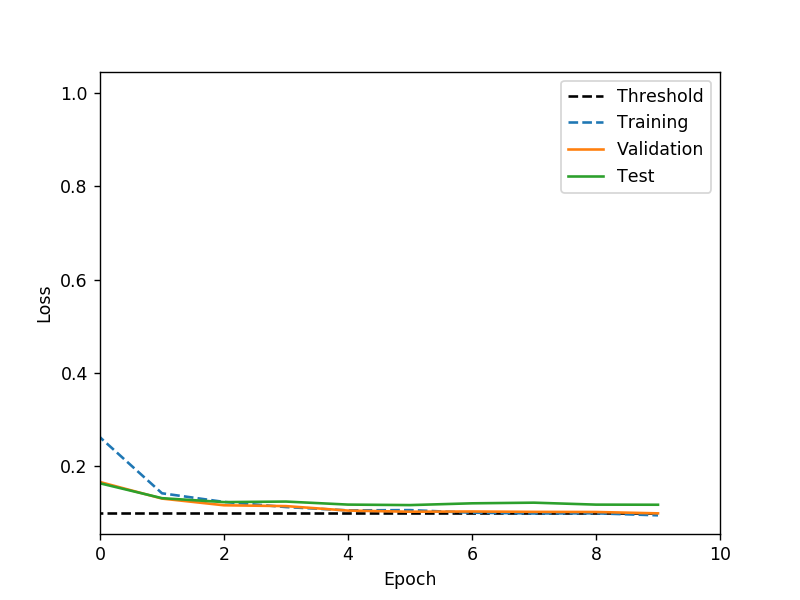

Done training.4         


In [22]:
%matplotlib notebook
import torch.optim as optim
import matplotlib.pyplot as plt

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.0004) # 0.0004 GOOD

epochs = 10
validation_threshold = 0.1

plt_count = -1
plt_thr = ([plt_count], [validation_threshold])
plt_loss = ([plt_count], [1])
plt_valid = ([plt_count], [1])
plt_test = ([plt_count], [1])
fig = plt.figure()
ax = fig.add_subplot()
line0, = ax.plot(plt_thr[0], plt_thr[1], 'k--', label = 'Threshold')  # Threshold line
line1, = ax.plot(plt_loss[0], plt_loss[1], '--', label = 'Training') # Training loss
line2, = ax.plot(plt_valid[0], plt_valid[1], label = 'Validation')     # Validation loss
line3, = ax.plot(plt_test[0], plt_test[1], label = 'Test')       # Test loss
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.set_xlim(-1, 0)
fig.canvas.draw()
fig.canvas.flush_events()

for epoch in range(epochs):
    train_losses = []
    for input, target, weigth in train_dataloader:
        input = [tensor.to(device, non_blocking = True).float() for tensor in input]
        target = target.to(device, non_blocking = True).float()
        weigth = weigth.to(device, non_blocking = True).float()
        
        criterion = nn.BCELoss(weigth)
        net.zero_grad()
        output = net(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.data)
        print('train: ' + str(len(train_losses)) + '/' + str(len(train_dataloader)) + '     ', end = '\r')
    train_loss = np.sum(train_losses) / len(train_losses)
        
        
    validation_losses = []
    with torch.no_grad():
        for input, target, weigth in validation_dataloader:
            input = [tensor.to(device, non_blocking = True).float() for tensor in input]
            target = target.to(device, non_blocking = True).float()
            weigth = weigth.to(device, non_blocking = True).float()
            
            criterion = nn.BCELoss(weigth)
            output = net(input)
            loss = criterion(output, target)
            validation_losses.append(loss.data)
            print('validation: ' + str(len(validation_losses)) + '/' + str(len(validation_dataloader)) + '     ', end = '\r')
    validation_loss = np.sum(validation_losses) / len(validation_losses)
    
    test_losses = []
    with torch.no_grad():
        for input, target, weigth in test_dataloader:
            input = [tensor.to(device, non_blocking = True).float() for tensor in input]
            target = target.to(device, non_blocking = True).float()
            weigth = weigth.to(device, non_blocking = True).float()
            
            criterion = nn.BCELoss(weigth)
            output = net(input)
            loss = criterion(output, target)
            test_losses.append(loss.data)
            print('test: ' + str(len(test_losses)) + '/' + str(len(test_dataloader)) + '     ', end = '\r')
    test_loss = np.sum(test_losses) / len(test_losses)
            
    plt_count += 1
    plt_thr[0].append(plt_count)
    plt_thr[1].append(validation_threshold)
    plt_loss[0].append(plt_count)
    plt_loss[1].append(train_loss)
    plt_valid[0].append(plt_count)
    plt_valid[1].append(validation_loss)
    plt_test[0].append(plt_count)
    plt_test[1].append(test_loss)
    line0.set_xdata(plt_thr[0])
    line0.set_ydata(plt_thr[1])
    line1.set_xdata(plt_loss[0])
    line1.set_ydata(plt_loss[1])
    line2.set_xdata(plt_valid[0])
    line2.set_ydata(plt_valid[1])
    line3.set_xdata(plt_test[0])
    line3.set_ydata(plt_test[1])
    ax.set_xlim(0, plt_count + 1)
    fig.canvas.draw()
    fig.canvas.flush_events()
    
    
    if validation_loss <= validation_threshold:
        print('Done training.')
        break

In [23]:
test_dataloader = DataLoader(test_dataset, batch_size = 1, num_workers = 8)
test_count = 0
correct = 0
with torch.no_grad():
    for input, target, weigth in test_dataloader:
        input = [tensor.to(device, non_blocking = True).float() for tensor in input]
        target = target.to(device, non_blocking = True).float()
        weigth = weigth.to(device, non_blocking = True).float()
        output = net(input)
        if target.max(1)[1] == output.max(1)[1]:
            correct += 1
        test_count += 1
        print('test: ' + str(test_count) + '/' + str(len(test_dataloader)) + ' accuracy: ' + str(correct / test_count), end = '\r')